# Human Tumor Microarray Data
A gene expression dataset collects together the expression values from a series of DNA microarray experiments, with each column representing an experiment. There are therefore several thousand rows representing individual genes, an tens of columns representing samples: in the particular example of Figure 1.3 there are 6830 genes (rows) and 64 samples (columns). The samples are 64 cancer tumors from different patients. The challenge here is to understand how the genes and samples are organized.

In [1]:
import pandas as pd
from matplotlib import gridspec, transforms, pyplot as plt
from matplotlib.colors import LinearSegmentedColormap, BoundaryNorm
import numpy as np

%matplotlib inline

# define plots common properties and color constants
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['axes.linewidth'] = 0.5
GRAY1, GRAY4, GRAY7 = '#231F20', '#646369', '#929497'

## Load and Prepare Data

In [2]:
data = pd.read_csv("../data/nci.data.csv", sep=',')
labels = pd.read_csv("../data/nci.label.txt")
labels['type'] = labels['type'].str.strip()
# combine some groups
labels_grp = labels.copy()
labels_grp.loc[labels_grp['type'] == 'K562A-repro', 'type'] = 'K562'
labels_grp.loc[labels_grp['type'] == 'K562B-repro', 'type'] = 'K562'
labels_grp.loc[labels_grp['type'] == 'MCF7A-repro', 'type'] = 'MCF7'
labels_grp.loc[labels_grp['type'] == 'MCF7D-repro', 'type'] = 'MCF7'

# columns (each column is one case)
sample_columns = [f's{i+1}' for i in range(64)]

X = data[sample_columns].values
y = labels['type'].values
y_grp = labels_grp['type'].values

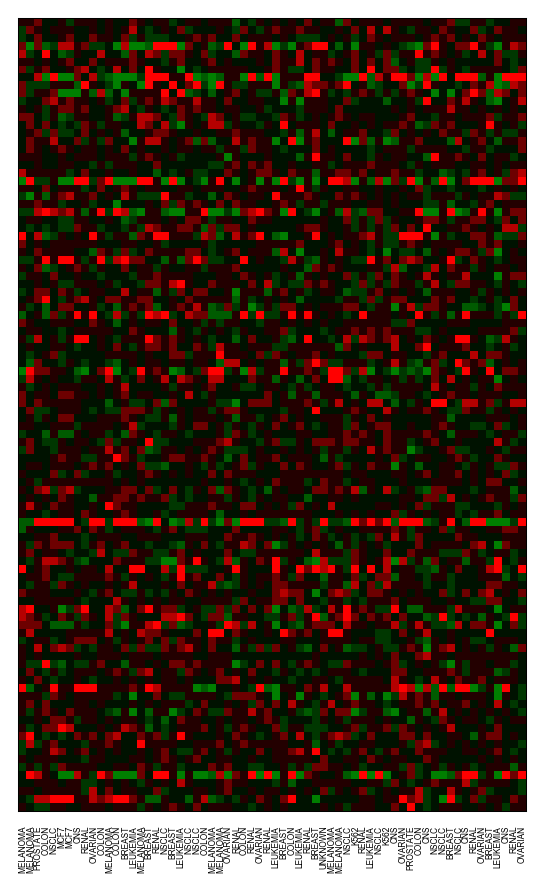

In [3]:
# PAGE 6. FIGURE 1.3. DNA microarray data: expression matrix of 6830 genes
#         (rows) and 64 samples (columns), for the human tumor data. Only a
#         random sample of 100 rows are shown. The diaplay is a heat map,
#         ranging from bright green (negative, under expressed) to bright red
#         (positive, over expressed). Missing values are gray. The rows and
#         columns are displayed in a randomly chosen order.
cmap = LinearSegmentedColormap.from_list('cm', ['g', 'black', 'r'], N=256)
bounds = np.arange(-2, 2.5, .5)
norm = BoundaryNorm(bounds, cmap.N)

rand_rows = np.random.choice(range(X.shape[0]), 100, replace=False)
rand_columns = np.random.choice(range(X.shape[1]), X.shape[1], replace=False)
rand_data = X[rand_rows][:, rand_columns]

fig, ax = plt.subplots(figsize=(15, 7), dpi=150)
ax.imshow(rand_data, interpolation='none', norm=norm, cmap=cmap)
ax.tick_params(bottom=False, left=False, labelleft=False)
plt.setp(ax, xticks=list(range(64)))
_ = ax.set_xticklabels(y_grp[rand_columns], rotation=90, ha='center', size=4)

## K-means Clustering

In [4]:
from sklearn.cluster import KMeans
from collections import Counter

In [5]:
n_clusters = 3
kmeans = KMeans(n_clusters=n_clusters, random_state=1).fit(X.T)
clusters = kmeans.predict(X.T)
cluster_counts = [Counter(y_grp[clusters == c]) for c in range(3)]

In [6]:
# PAGE 513. TABLE 14.2. Human tumor data: number of cancer cases of each type,
#           in each of the three clusters from K-means clustering.
for grp in [['BREAST', 'CNS', 'COLON', 'K562', 'LEUKEMIA', 'MCF7'],
            ['MELANOMA', 'NSCLC', 'OVARIAN', 'PROSTATE', 'RENAL', 'UNKNOWN']]:
    print('-'*70)
    print('Cluster  |' + ''.join([f'{n:^10}' for n in grp]))
    print('-'*70)
    for c in range(n_clusters):
        counts = cluster_counts[c]
        cnts = [counts[t] if t in counts else 0 for t in grp]
        print(f'{c+1:<9}|' + ''.join([f'{c:^10}' for c in cnts]))

----------------------------------------------------------------------
Cluster  |  BREAST     CNS      COLON      K562    LEUKEMIA    MCF7   
----------------------------------------------------------------------
1        |    3         5         0         0         0         0     
2        |    2         0         0         0         0         0     
3        |    2         0         7         2         6         2     
----------------------------------------------------------------------
Cluster  | MELANOMA   NSCLC    OVARIAN   PROSTATE   RENAL    UNKNOWN  
----------------------------------------------------------------------
1        |    1         8         6         2         9         1     
2        |    7         0         0         0         0         0     
3        |    0         1         0         0         0         0     


## Hierarchical Clustering

In [7]:
from scipy.cluster.hierarchy import linkage, dendrogram

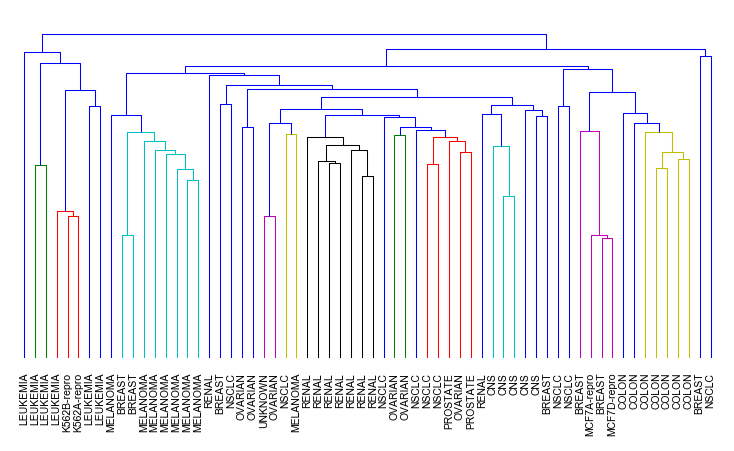

In [8]:
# override default linewidth
plt.rcParams['lines.linewidth'] = 0.5

# PAGE 522. FIGURE 14.12. Dendrogram from agglomerative hierarchical clustering
#           with average linkage to the human tumor microarray data.
lnk = linkage(X.T, method='average')
fig, ax = plt.subplots(figsize=(6, 3), dpi=150)
_ = dendrogram(lnk, labels=y, leaf_font_size=5)
ax.tick_params(bottom=False, left=False, labelleft=False)
for s in ax.spines.values():
    s.set_visible(False)

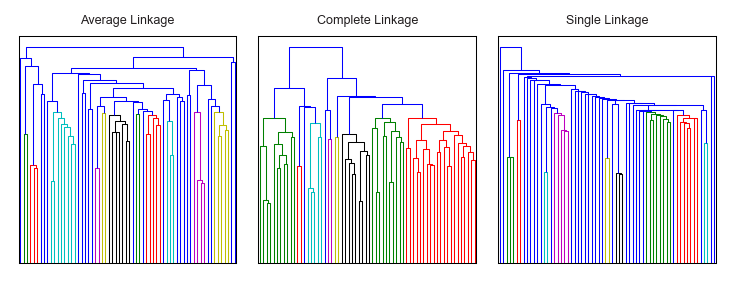

In [9]:
# PAGE 524. FIGURE 14.13. Dendrograms from agglomerative hierarchical
#           clustering of human tumor microarray data.
fig, axarr = plt.subplots(1, 3, figsize=(6, 2), dpi=150)
plt.subplots_adjust(wspace=0.1)
titles = {'average': 'Average Linkage',
          'complete': 'Complete Linkage',
          'single': 'Single Linkage'}
for i, method in enumerate(['average', 'complete', 'single']):
    ax = axarr[i]
    plt.axes(ax)
    lnk = linkage(X.T, method=method)
    _ = dendrogram(lnk, labels=y)
    ax.tick_params(
        bottom=False, labelbottom=False, left=False, labelleft=False)
    plt.title(titles[method], fontsize=6, color=GRAY1)

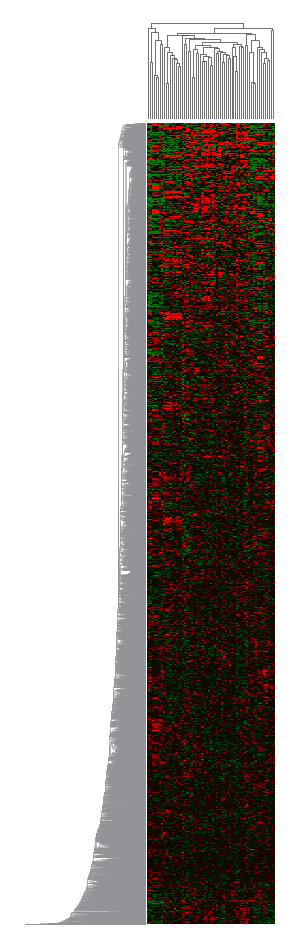

In [10]:
# PAGE 527. FIGURE 14.14. DNA microarray data: average linkage hierarchical
#           clustering has been applied independently to the rows (genes) and
#           columns (samples), determining the ordering of the rows and columns
#           (see text). The colors range from bright green (negative, under-
#           expressed) to bright red (positive, over-expressed).
fig, axarr = plt.subplots(figsize=(2.2, 8), dpi=150)
gs1 = gridspec.GridSpec(
    2, 2,
    width_ratios=[1, 1],
    height_ratios=[1, 8])
ax1 = plt.subplot(gs1[0, 0])
ax2 = plt.subplot(gs1[0, 1])
ax3 = plt.subplot(gs1[1, 0])
ax4 = plt.subplot(gs1[1, 1])
axarr = [ax1, ax2, ax3, ax4]
plt.subplots_adjust(wspace=0.01, hspace=0.01)

plt.rcParams['lines.linewidth'] = 0.3
plt.axes(ax2)
lnk_top = linkage(X.T, method='average')
dg_top = dendrogram(
    lnk_top, above_threshold_color=GRAY1, color_threshold=0)

plt.axes(ax3)
lnk_left = linkage(X, method='average')
dg_left = dendrogram(lnk_left, orientation='left', above_threshold_color=GRAY7,
                     color_threshold=0)

data = X[np.array(dg_left['leaves'])][:, np.array(dg_top['leaves'])]
ax4.set_xlim(0, 60)
ax4.imshow(data, interpolation='none', norm=norm, cmap=cmap, aspect='auto')

for ax in axarr:
    ax.tick_params(
        bottom=False, labelbottom=False, left=False, labelleft=False,
        top=False, labeltop=False, right=False, labelright=False)
    for s in ax.spines.values():
        s.set_visible(False)